# Atlas notebooks

***

> This notebook reproduces and extends parts of the figures and products of the AR6-WGI Atlas. It is part of a notebook collection available at https://github.com/IPCC-WG1/Atlas for reproducibility and reusability purposes. This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0).
>
> ![Creative Commons License >](https://i.creativecommons.org/l/by/4.0/88x31.png)

## Computing and visualization of precipitation linear trends during the observed period (1980-2014)

07/07/2021

**J. Baño-Medina** ([Santander Meteorology Group](http://meteo.unican.es), Instituto de Física de Cantabria, CSIC-UC, Santander, Spain)

We present an illustrative example to use the climate4R framework to depict the observed linear trends and the time series of precipitation anomalies over a selected time period for the W5E5 observational dataset. North America is used as an example target region. Indications are also provided to apply the methodology to other variables, such as temperature.

### Load packages

The notebok relies on several climate4R packages:

In [2]:
options(java.parameters = "-Xmx8g") # extends Java (loadeR) memory allocation
library(loadeR)
library(transformeR)
library(visualizeR) # spatialPlot
library(geoprocessoR)
library(climate4R.indices) # linearTrend

Along with other libraries, namely:

 * `magrittr` is used to pipe (%>%) sequences of data operations
 * `gridExtra` provides plotting functionalities
 * `sp` and `rgdal` provide geospatial tools
 * `RColorBrewer` provides color palettes

In [4]:
library(magrittr)
library(gridExtra)
library(sp)
library(RColorBrewer)
library(rgdal) # readOGR

### Set parameters
We can tune these parameters to define characteristics of the data to be loaded (e.g., variable to process, domain boundaries, temporal period)

In [5]:
var <- "pr"
latLim <- c(12,74)
lonLim <- c(-170,-50)
years <- 1980:2014

You can find out other variable names by issuing `C4R.vocabulary()`.

The following setting control the plots below. They define colorbar ranges and, thus, depend on the variable units.

In [6]:
colorScale_climatology <- seq(0, 10, 1)
colorScale_trends <- seq(-0.1, 0.1, 0.01)
ylim_anom <- c(-1,1)

### Load static data

We will load the boundaries of the IPCC [reference regions](../reference-regions) v4:

In [7]:
regs <- get(load("../reference-regions/IPCC-WGI-reference-regions-v4_R.rda")) %>% as("SpatialPolygons")
regs.area <- c("NWN", "NEN", "WNA", "CNA","ENA","NCA","SCA","CAR") # North America regions

We load also the coastlines, to be used in the spatial maps below. These are available in the [auxiliary-material](./auxiliary-material) folder:

In [8]:
coast <- readOGR("auxiliary-material/WORLD_coastline.shp") 

OGR data source with driver: ESRI Shapefile 
Source: "/Users/jorgebanomedina/Desktop/climate4R.projects/Atlas/notebooks/auxiliary-material/WORLD_coastline.shp", layer: "WORLD_coastline"
with 127 features
It has 2 fields


### Load observations from the User Data Gateway

> This section takes long to execute due to intensive remote data loading. See the next section ([Load data from file](#Load-data-from-file)) to load these data from a local copy available in the repository and continue with the notebook operations.

To load data stored in the User Data Gateway (similar to loading data from a local directory), we rely on the C4R library called `climate4R.UDG`, that contains 2 main functions: `UDG.datasets` and `loadGridData`.

`UDG.datasets` lists all the datasets accessible from the UDG.

In [9]:
library(climate4R.UDG)
UDG.datasets()$OBSERVATIONS

Label names are returned, set argument full.info = TRUE to get more information



[1] "WATCH_WFDEI"            "PIK_Obs-EWEMBI"         "E-OBS_v14_0.50regular" 
 [4] "E-OBS_v14_0.44rotated"  "E-OBS_v14_0.25regular"  "E-OBS_v14_0.22rotated" 
 [7] "E-OBS_v17_0.50regular"  "E-OBS_v17_0.44rotated"  "E-OBS_v17_0.25regular" 
[10] "E-OBS_v17_0.22rotated"  "E-OBS_v21e_0.10regular" "UC-Spain02_11"         
[13] "UC-Spain02_22"          "UC-Spain02_44"          "GPCCmon"               
[16] "GPCC"                   "GPCPmon"                "GPCP"                  
[19] "CRU-TS"                 "BEST"                   "BESTmon"               
[22] "W5E5"

We see that, among others, the W5E5 dataset is available from the UDG. To load W5E5 we would just input the corresponding label to the `dataset` argument in `loadGridData`. We load them year by year in the following loop to save memory. We end up with a dataset (a climate4R Grid object) containing yearly averages for the region selected. The following piece of code takes about 1 minute per year loaded (depends on your network connection speed).

```R
grid.list <- list()
for (year in years){
    message(" ** Reading year ", year)
    grid.list[[as.character(year)]] <- loadGridData(
        dataset = "W5E5", var = var,
        latLim = latLim, lonLim = lonLim, years = year
    ) %>%
    aggregateGrid(aggr.y = list(FUN = "mean", na.rm = TRUE)) 
}
grid <- bindGrid(grid.list, dimension = "time")                                         
```

These data took long to generate. We could save them for later use (see next section) by building on library `loadeR.2nc`, which contains the function `grid2nc`. The latter permits to save as netCDF files, C4R objects.

```R
library(loadeR.2nc) # 
grid2nc(grid, NetCDFOutFile = "auxiliary-material/W5E5_NorthAmerica_pr_1980-2014_yearly.nc4")
```

### Load data from file

Skip this section if you sucessfully loaded your data from the User Data Gateway. For a fast loading of the required data, you can use a copy of the yearly averaged precipitation available in the `auxiliary-material` folder:

In [10]:
grid <- loadGridData("auxiliary-material/W5E5_NorthAmerica_pr_1980-2014_yearly.nc4", var = "pr")
attr(grid$xyCoords, "projection") <- "+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0"

[2021-07-22 20:08:55] Defining geo-location parameters

[2021-07-22 20:08:55] Defining time selection parameters

[2021-07-22 20:08:55] Retrieving data subset ...

[2021-07-22 20:08:57] Done



### Plot climatology

We define the geographical projection.

In [11]:
proj4string(regs) <- CRS(attr(grid$xyCoords,"projection"))

Warning message in proj4string(obj):
“CRS object has comment, which is lost in output”
Warning message in `proj4string<-`(`*tmp*`, value = new("CRS", projargs = "+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0")):
“A new CRS was assigned to an object with an existing CRS:
+proj=longlat +ellps=WGS84 +no_defs
without reprojecting.
For reprojection, use function spTransform”


We compute the climatology by calling the `climatology` function and then use `spatialPlot` from library `visualizeR` to depict it. We introduce the IPCC regions of interest in the `sp.layout` argument.

[2021-07-22 20:09:06] - Computing climatology...

[2021-07-22 20:09:06] - Done.



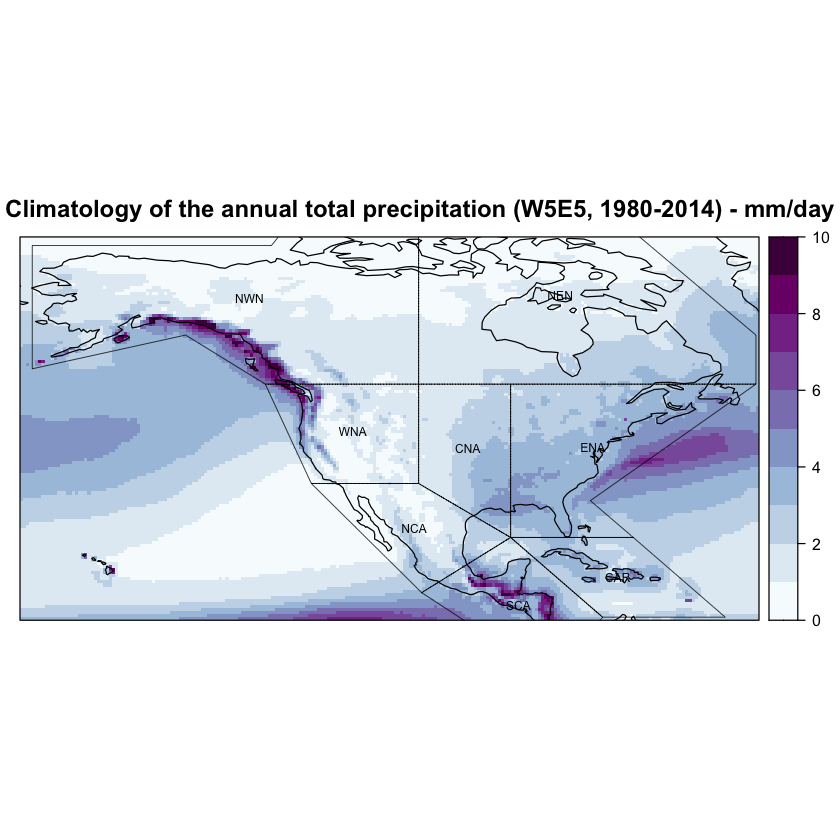

In [12]:
spatialPlot(climatology(grid),
            at = colorScale_climatology, 
            set.min = colorScale_climatology[1],
            set.max = colorScale_climatology[length(colorScale_climatology)],
            backdrop.theme = "coastline",
            col.regions = brewer.pal(n = 9, "BuPu") %>% colorRampPalette(),
            main = paste("Climatology of the annual total precipitation (W5E5, 1980-2014) - mm/day"),
            sp.layout = list(
                list(regs[regs.area], first = FALSE, lwd = 0.6),
                list("sp.text", coordinates(regs[regs.area]), names(regs[regs.area]), first = FALSE, cex = 0.6)
))

### Compute and plot trends

We call the function `linearTrend` that computes the linear points at gridbox level and returns all the involved statistics (e.g., p-value of the estimated slope). We subset the slope ("b") among all the statistics returned, by calling `subsetGrid`. 

In [13]:
trendGrid <- linearTrend(grid, p = 0.9) %>% subsetGrid(var = "b")

The slope of the linear trend is estimated based on the temporal resolution of the data. Please consider using the function aggregateGrid prior to the call of linearTrend to adequate the data to your resolution of interest.

[2021-07-22 20:09:12] - Computing climatology...

[2021-07-22 20:09:13] - Done.

Warning message:
“Only one grid passed as input. Nothing was done”


We could save these climate products as NetCDF files using `loadeR.2nc` C4R library.

```R
grid2nc(trendGrid, NetCDFOutFile = "trends.nc4")
```

We use function `overGrid` to mask the values outside the IPCC regions of interest to this use-case.

In [14]:
trendGrid %<>% overGrid(regs[regs.area])

We rely on `spatialPlot` from visualizeR, to depict the trend map.

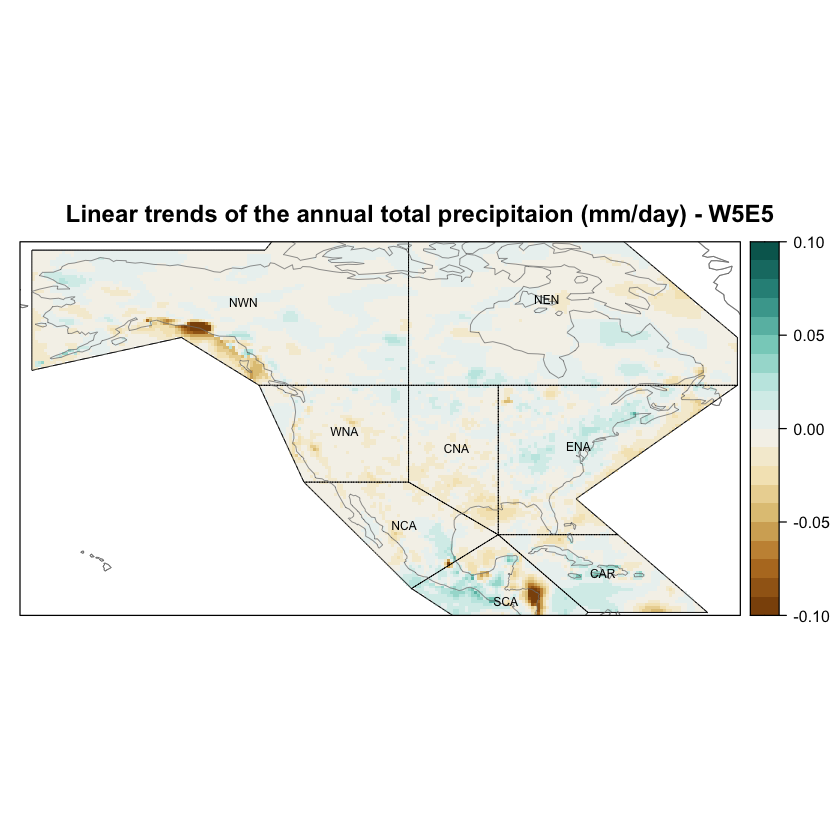

In [15]:
spatialPlot(trendGrid, 
            col.regions = brewer.pal(n = 9, "BrBG") %>% colorRampPalette(),
            at = colorScale_trends, 
            set.min = colorScale_trends[1],
            set.max = colorScale_trends[length(colorScale_trends)],
            main = paste("Linear trends of the annual total precipitaion (mm/day) - W5E5"),
            sp.layout = list(  
            list(regs[regs.area], first = FALSE, lwd = 0.6),
            list(coast, col = "gray50", first = FALSE, lwd = 0.6),  
            list("sp.text", coordinates(regs[regs.area]), names(regs[regs.area]), first = FALSE, cex = 0.6)
))

#### Trend significance

Next, we show how to add trend statistical significance information as a hatching. For this purpose, we repeat the process but retrieving the p-values of the linear trends. Therefore we subset the variable `"pval"`using `subsetGrid`. Then we mask the p-values over the IPCC regions using function `overGrid`. But previously we build an artificial land-sea mask to avoid R misuses with NaN data over the sea when calculating the p-values. Finally, we convert the p-values to a binary field using a threshold of 0.1, when 0 (1) indicates that the trend is significant (non-significant).

In [29]:
mask <- binaryGrid(climatology(grid),condition = "GE", threshold = 0, values = c(NA,1))
pvalGrid <- linearTrend(grid, p = 0.9) %>% subsetGrid(var = "pval") %>% gridArithmetics(mask) 
pvalGrid <- overGrid(pvalGrid, regs[regs.area]) %>% binaryGrid(threshold = 0.1, condition = "GT")

[2021-07-12 17:08:07] - Computing climatology...

[2021-07-12 17:08:07] - Done.

The slope of the linear trend is estimated based on the temporal resolution of the data. Please consider using the function aggregateGrid prior to the call of linearTrend to adequate the data to your resolution of interest.

[2021-07-12 17:08:07] - Computing climatology...

[2021-07-12 17:08:08] - Done.

Warning message:
“Only one grid passed as input. Nothing was done”


We use the p-values computed above to perform hatching over the future spatial maps. To do so, we capsulate the function `map.hatching` in a 2-way loop that corresponds to each line in a 'x' symbol. An 'x' would be associated whenever the condition is fullfilled, in our case whenever at least half the gridpoints of the upscaled grid are non-significant (i.e., 0-valued in the binary p-value object, `pvalGrid`). We use the `mean` fuction as the upscaling aggregation function, moving from 0.5º of spatial resolution in the trends field, to 2º of spatial resolution in the hatching. The upscaled (hatching) grid resolution is based on parameter `d` of function `map.hatching`. In our case `d = 4`, and therefore spatial resolution = 4 x 0.5º = 2º.

In [30]:
l <- lapply(c("45","-45"), FUN = function(zz) {
  c(map.hatching(clim = climatology(pvalGrid), 
                 threshold = 0.5, 
                 condition = "GE", 
                 density = 4,
                 angle = zz, coverage.percent = 50,
                 upscaling.aggr.fun = list(FUN = "mean", na.rm = TRUE)
  ), 
  "which" = 1, lwd = 0.5)
})

[2021-07-12 17:08:18] - Computing climatology...

[2021-07-12 17:08:18] - Done.

[2021-07-12 17:08:19] - Computing climatology...

[2021-07-12 17:08:19] - Done.



We rely on `spatialPlot` from visualizeR, to depict the trend maps and include the p-value as hatching as a member of the `sp.layout` list.

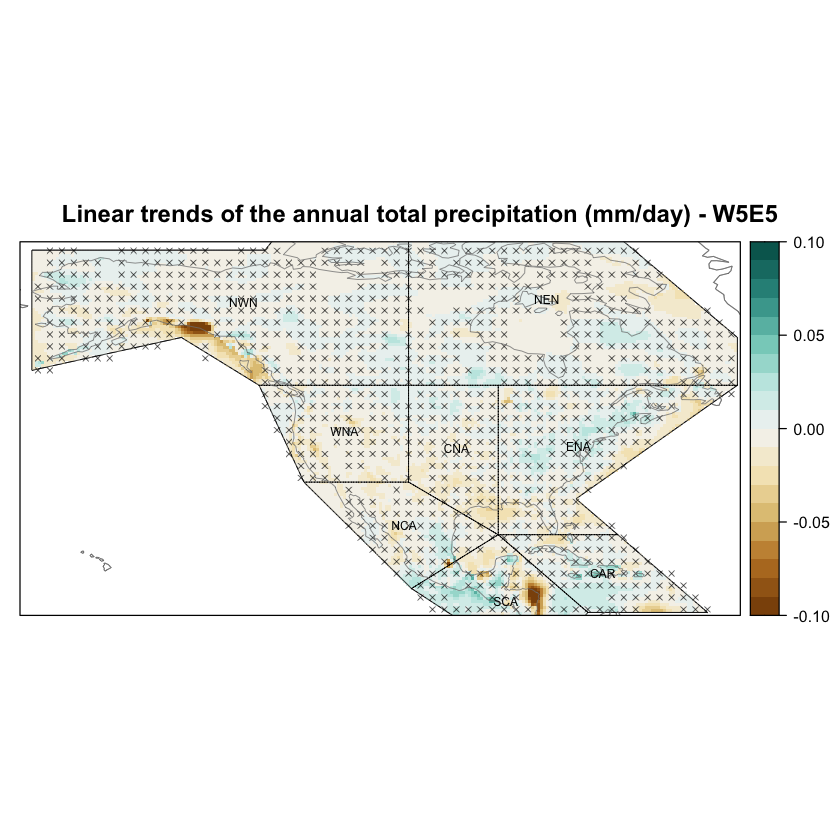

In [31]:
spatialPlot(trendGrid, 
            col.regions = brewer.pal(n = 9, "BrBG") %>% colorRampPalette(),
            at = colorScale_trends, 
            set.min = colorScale_trends[1],
            set.max = colorScale_trends[length(colorScale_trends)],
            main = paste("Linear trends of the annual total precipitation (mm/day) - W5E5"),
            sp.layout = list(
            l[[1]],l[[2]],  
            list(regs[regs.area], first = FALSE, lwd = 0.6),
            list(coast, col = "gray50", first = FALSE, lwd = 0.6),  
            list("sp.text", coordinates(regs[regs.area]), names(regs[regs.area]), first = FALSE, cex = 0.6)
))

### Anomaly time series

We loop over the IPCC regions to generate as many members as regions containing the temporal series. This would facilitate to obtain spatial averages over each region since their information has been split in members over an `R` list. To do so we rely on function `overGrid`.

In [23]:
grid.regs <- lapply(regs.area, function(r) overGrid(grid, regs[r]))
names(grid.regs) <- regs.area

We compute the anomalies by calling `scaleGrid` of `transformeR` and setting the argument `type = center` to substract the mean to the temporal series. Previously, we call `aggregateGrid` over the list of IPCC objets to average over each region and therefore output the temporal series for every North American IPCC region.

In [18]:
grid.anom <- lapply(grid.regs, function(x) {
    aggregateGrid(x, aggr.lat = list(FUN = "mean", na.rm = TRUE), aggr.lon = list(FUN = "mean", na.rm = TRUE))
} %>% scaleGrid(type = "center"))  

[2021-07-12 11:36:21] - Scaling ...

Calculating areal weights...

[2021-07-12 11:36:21] - Aggregating lat dimension...

[2021-07-12 11:36:22] - Done.

[2021-07-12 11:36:22] - Aggregating lon dimension...

[2021-07-12 11:36:22] - Done.

[2021-07-12 11:36:22] - Done

[2021-07-12 11:36:22] - Scaling ...

Calculating areal weights...

[2021-07-12 11:36:22] - Aggregating lat dimension...

[2021-07-12 11:36:22] - Done.

[2021-07-12 11:36:22] - Aggregating lon dimension...

[2021-07-12 11:36:22] - Done.

[2021-07-12 11:36:22] - Done

[2021-07-12 11:36:22] - Scaling ...

Calculating areal weights...

[2021-07-12 11:36:22] - Aggregating lat dimension...

[2021-07-12 11:36:22] - Done.

[2021-07-12 11:36:22] - Aggregating lon dimension...

[2021-07-12 11:36:22] - Done.

[2021-07-12 11:36:22] - Done

[2021-07-12 11:36:22] - Scaling ...

Calculating areal weights...

[2021-07-12 11:36:22] - Aggregating lat dimension...

[2021-07-12 11:36:22] - Done.

[2021-07-12 11:36:22] - Aggregating lon dimensi

Finally, we call `temporalPlot` of library `visualizeR` to depict the resulting anomaly time series.

The slope of the linear trend is estimated based on the temporal resolution of the data. Please consider using the function aggregateGrid prior to the call of linearTrend to adequate the data to your resolution of interest.

[2021-07-12 11:36:23] - Computing climatology...

[2021-07-12 11:36:23] - Done.

Warning message:
“Only one grid passed as input. Nothing was done”
pad applied on the interval: year

The slope of the linear trend is estimated based on the temporal resolution of the data. Please consider using the function aggregateGrid prior to the call of linearTrend to adequate the data to your resolution of interest.

[2021-07-12 11:36:23] - Computing climatology...

[2021-07-12 11:36:23] - Done.

Warning message:
“Only one grid passed as input. Nothing was done”
pad applied on the interval: year

The slope of the linear trend is estimated based on the temporal resolution of the data. Please consider using the function aggregateGrid prior to the call of linearTrend to adequate t

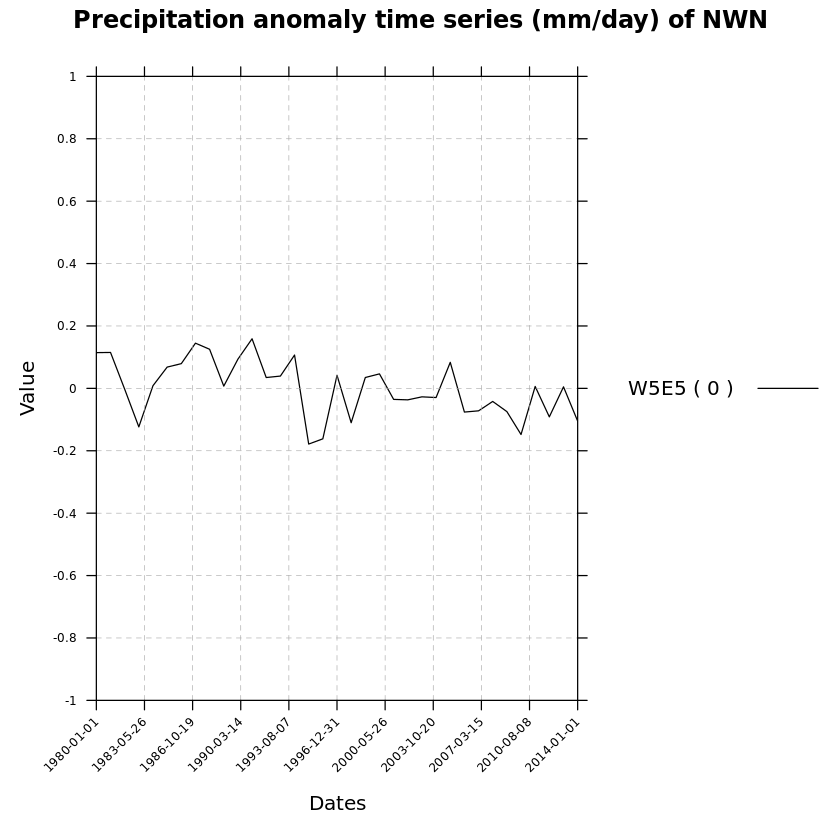

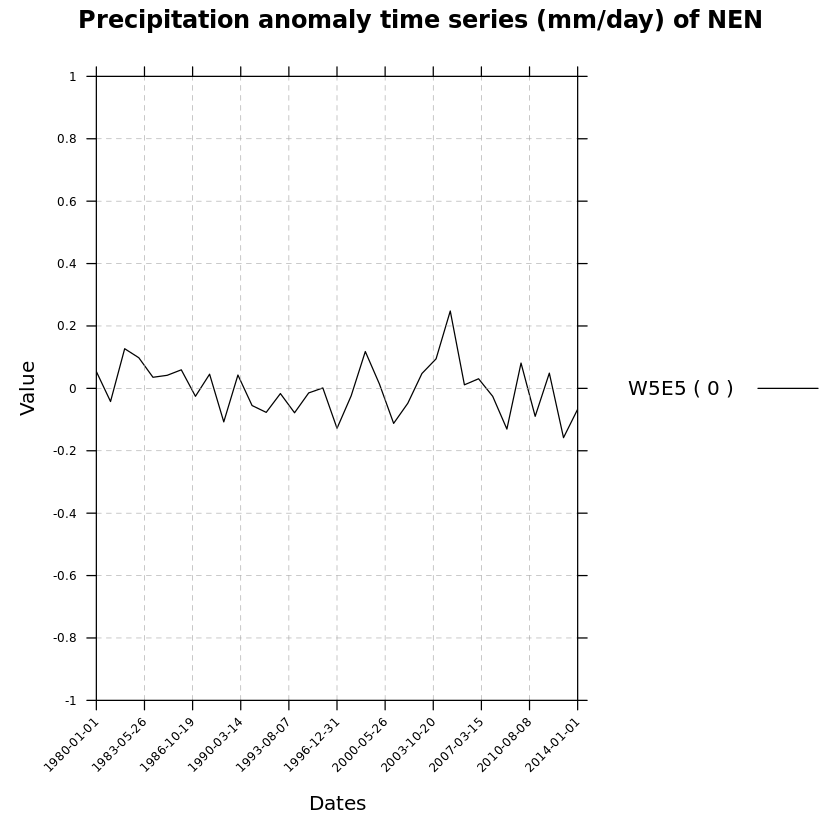

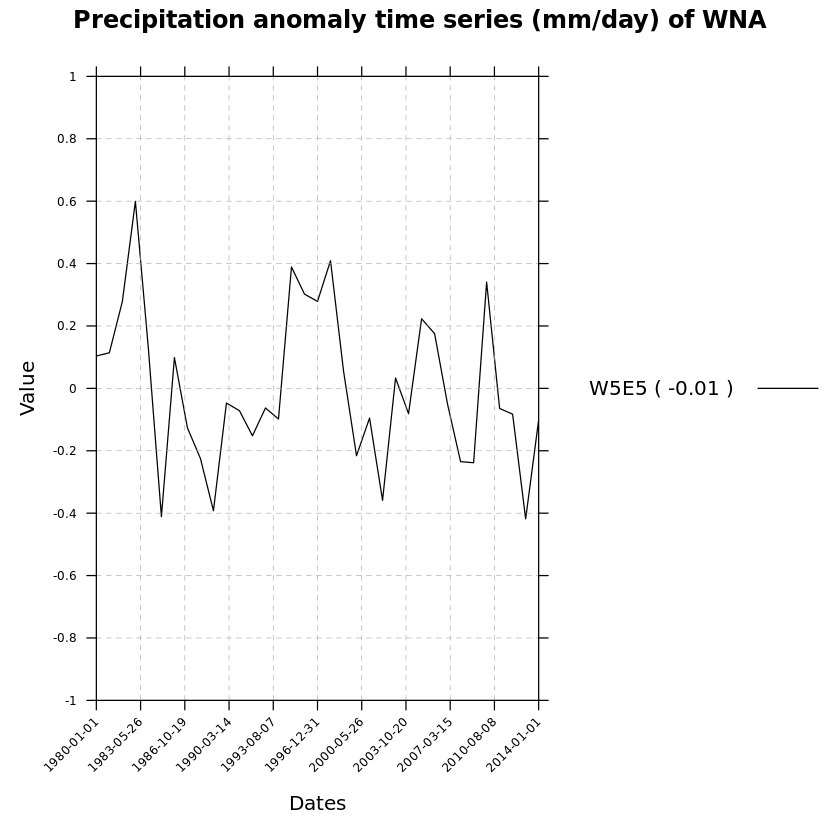

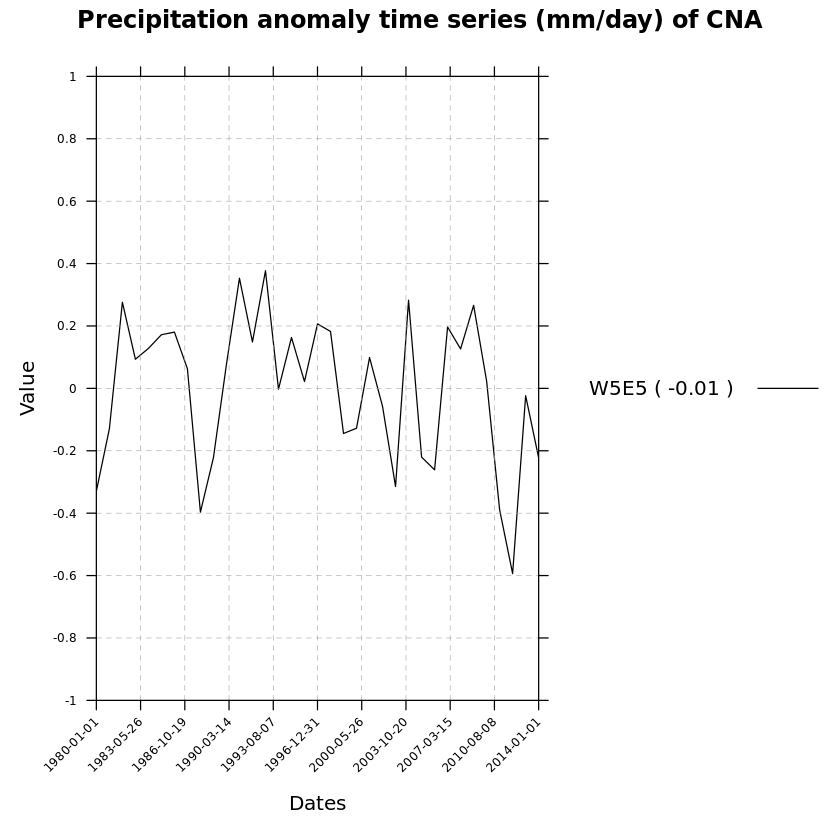

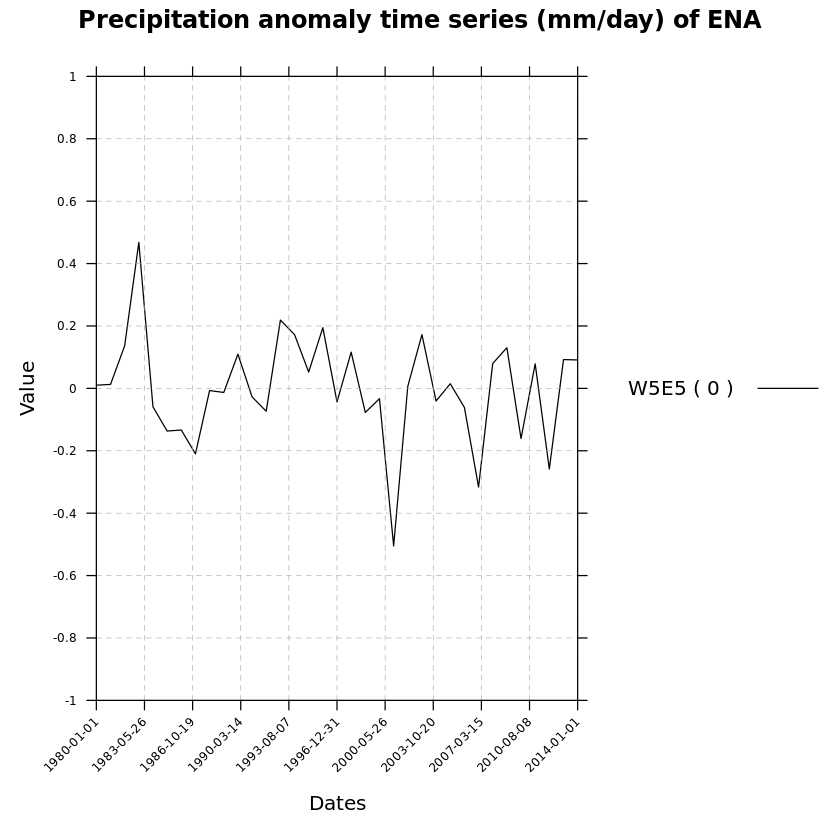

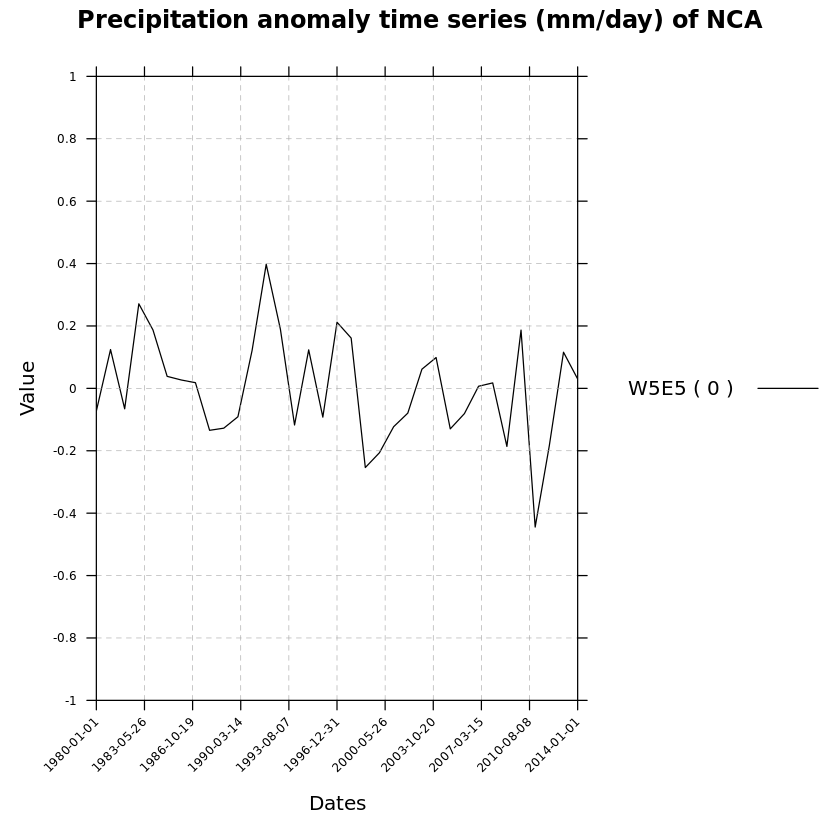

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]

[[8]]


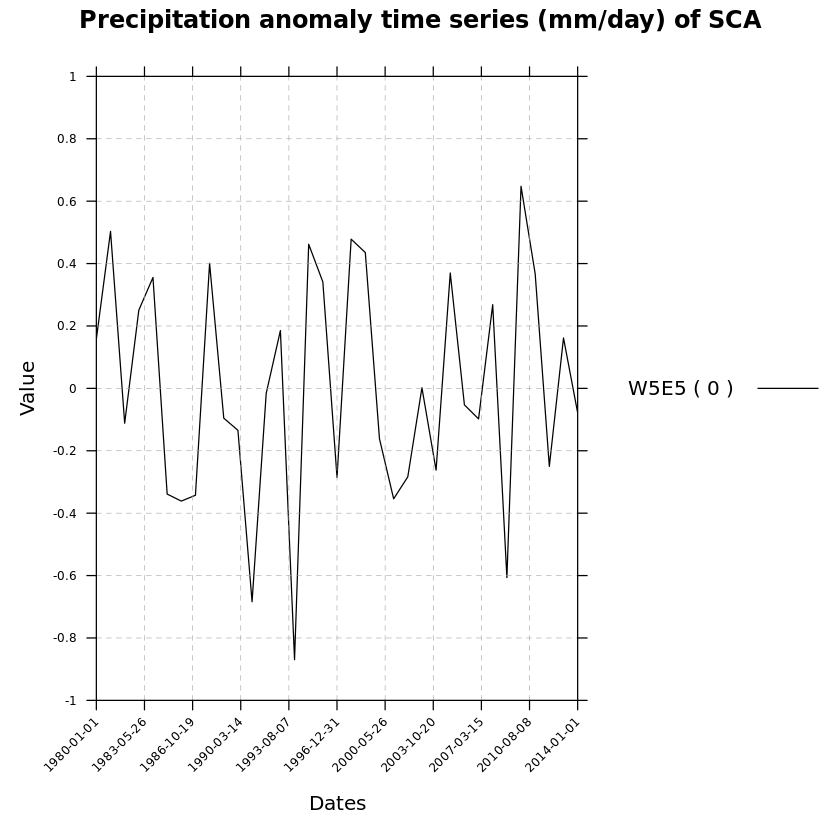

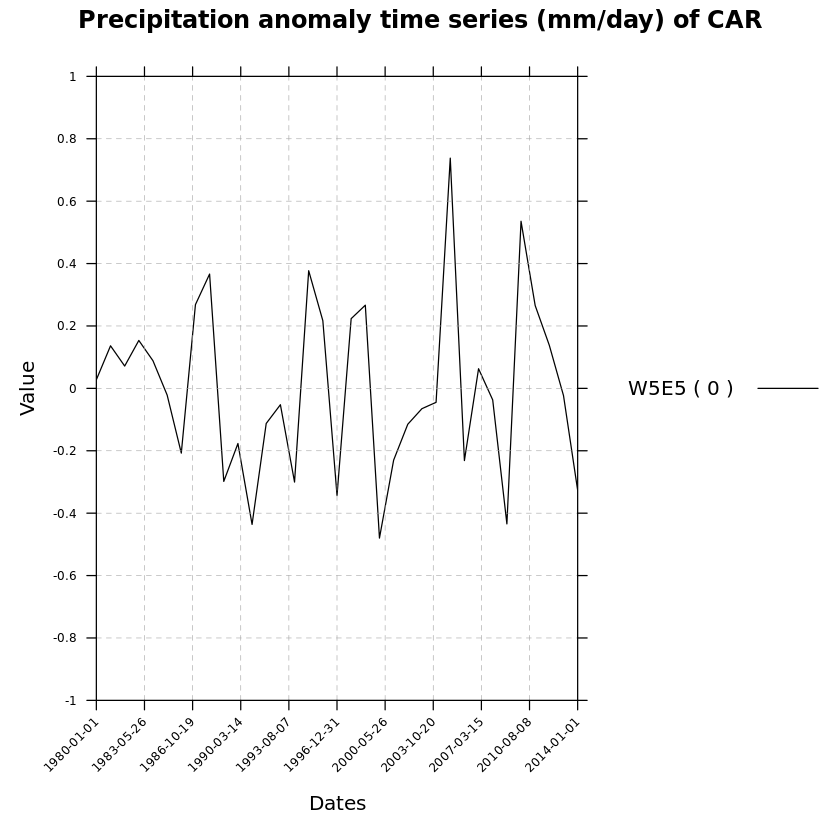

In [19]:
lapply(1:length(grid.anom), FUN = function(x) {
  aux <- (linearTrend(grid.anom[[x]], p = 0.9) %>% subsetGrid(var = "b"))$Data[1]
  
  key.trans <- list(space="right",
                    text=list(c(paste("W5E5","(",round(aux,digits=2),")"))),
                    lines=list(col=c("black"), lty = c(1)))                
  temporalPlot(grid.anom[[x]],
               xyplot.custom = list(
                 main = paste("Precipitation anomaly time series (mm/day) of",regs.area[x]),
                 ylim = ylim_anom,
                 key = key.trans   
               ))
})                

### Session info

In [20]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /srv/conda/envs/notebook/lib/libopenblasp-r0.3.15.so

locale:
 [1] LC_CTYPE=en_US.UTF-8          LC_NUMERIC=C                 
 [3] LC_TIME=en_US.UTF-8           LC_COLLATE=en_US.UTF-8       
 [5] LC_MONETARY=en_US.UTF-8       LC_MESSAGES=en_US.UTF-8      
 [7] LC_PAPER=en_US.UTF-8          LC_NAME=en_US.UTF-8          
 [9] LC_ADDRESS=en_US.UTF-8        LC_TELEPHONE=en_US.UTF-8     
[11] LC_MEASUREMENT=en_US.UTF-8    LC_IDENTIFICATION=en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] rgdal_1.5-16            RColorBrewer_1.1-2      sp_1.4-5               
 [4] gridExtra_2.3           magrittr_2.0.1          climate4R.indices_0.2.0
 [7] geoprocessoR_0.2.0      visualizeR_1.6.1        transformeR_2.1.2      
[10] loadeR_1.7.1            climate4R.UDG_0.2.3